# Mass fractions optimization using AixNet and Sybill 2.3c

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mass_fractions import *
from simulated_dipole import *


plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Comic Sans MS"
plt.rcParams["mathtext.it"] = "Comic Sans MS:italic"
plt.rcParams["mathtext.bf"] = "Comic Sans MS:bold"

dd = np.load('simulated_data.npy', allow_pickle=True).item()
print(dd.keys())

dd['charge'] = np.empty_like(dd['mass'])
dd['charge'][np.where(dd['mass']==1)] = 1
dd['charge'][np.where(dd['mass']==4)] = 2
dd['charge'][np.where(dd['mass']==16)] = 8
dd['charge'][np.where(dd['mass']==56)] = 26

print(dd['charge'])
print(len(dd['charge']))

dict_keys(['dnn_axis', 'dnn_core', 'dnn_energy', 'dnn_xmax', 'event_id', 'auger_id', 'sd_id', 'is_saturated', 'core', 'axis', 'energy', 'xmax', 'element', 'mass', 'merit', 'fd_energy', 'fd_axis', 'sd_energy', 'sd_axis', 'sd_galactic_latitude', 'sd_galactic_longitude', 'sd_core', 'univ_energy', 'univ_axis', 'delta_mean_delta', 'delta_xmax', 'delta_energy', 'muon_number'])
[ 1.  1.  1. ... 26. 26. 26.]
13701


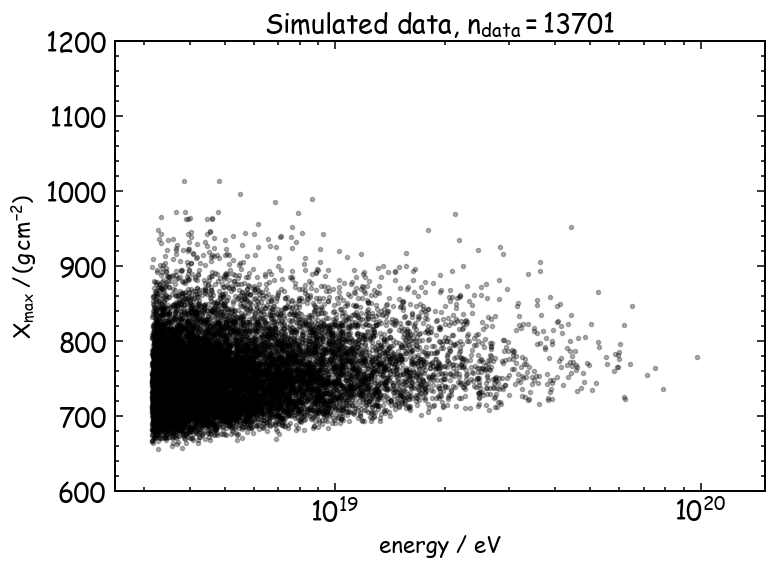

In [6]:
plt.figure(figsize=(10,6))
# plt.title('Comic Sans!!!')
plt.title(f'Simulated data, $n_{{data}}={len(dd['energy'])}$')
plt.scatter(dd['energy']*1e18, dd['dnn_xmax'], alpha=0.3, color='k')
plt.xlabel(r'energy / eV')
plt.ylabel(r'$X_\mathrm{max} \, \, / \, (g \, cm^{-2})$')
plt.xscale('log')
plt.ylim(600, 1200)
plt.xlim(2.5e18, 150e18)
plt.show()

### Defining bins

In [7]:
smd = SMD_method()

thres_values = np.linspace(np.min(dd['dnn_xmax']), np.max(dd['dnn_xmax']), 6)
# print(thres_values)
results_dict = {'emin': [], 'emax': [], 'light': [], 'heavy': [], 'SMD': []}

for ee in range(len(energies)-1):
    e_min = energies[ee]/1e18
    e_max =energies[ee+1]/1e18

    e_mask = (dd['energy']<e_max)&(dd['energy']>=e_min)
    data = dict_cutter(dd, e_mask)
    print(len(data['sd_id']))

    for i in range(1, len(thres_values) - 2):
        thres_h = thres_values[i]

        for j in range(i + 1, len(thres_values) - 1):

            thres_l = thres_values[j]
            mask_h = (data['dnn_xmax']<thres_h)
            mask_l = (data['dnn_xmax']>thres_l)
            light_frac = dict_cutter(data, mask_l)
            heavy_frac = dict_cutter(data, mask_h)

            value = smd.quantify_SMD(light_frac['energy'], light_frac['charge'], heavy_frac['energy'], heavy_frac['charge'], d_max=1)

            results_dict['emin'].append(e_min)
            results_dict['emax'].append(e_max)
            results_dict['light'].append(thres_l)
            results_dict['heavy'].append(thres_h)
            results_dict['SMD'].append(value)

            # print(thres_h, thres_l, value)



6139
2105
541
119


/tmp/ipykernel_198264/1111872321.py:25: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(masked_SMD, aspect='auto', origin='lower',
/tmp/ipykernel_198264/1111872321.py:25: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(masked_SMD, aspect='auto', origin='lower',


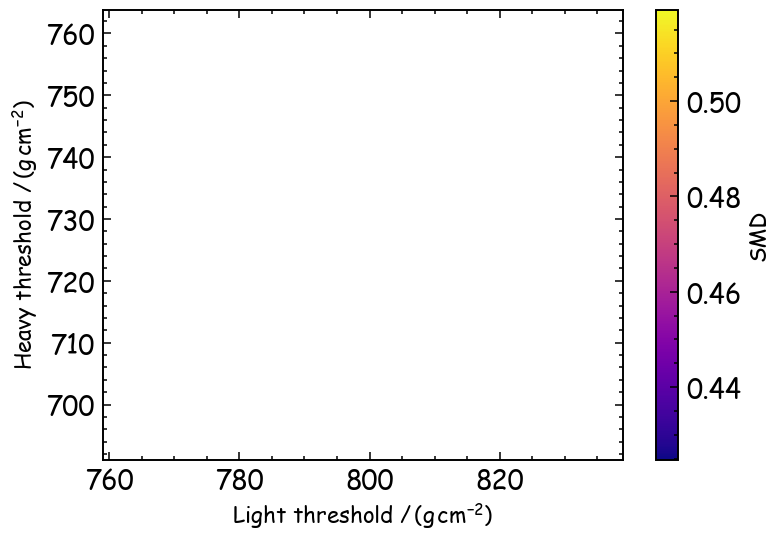

In [8]:
light_vals = np.array(results_dict['light'][results_dict['emin']==4])
heavy_vals = np.array(results_dict['heavy'][results_dict['emin']==4])
SMD_vals = np.array(results_dict['SMD'][results_dict['emin']==4])

# Create grid
unique_light = np.unique(light_vals)  # Unique x values
unique_heavy = np.unique(heavy_vals)  # Unique y values

# Reshape SMD values into a 2D array
SMD_grid = np.zeros((len(unique_heavy), len(unique_light)))

for i, h in enumerate(unique_heavy):
    for j, l in enumerate(unique_light):
        mask = (heavy_vals == h) & (light_vals == l)
        if np.any(mask):
            SMD_grid[i, j] = SMD_vals[mask][0]  # Take first match

masked_SMD = np.ma.masked_where(unique_light[None, :] <= unique_heavy[:, None], SMD_grid)

# Plot heatmap with masked values
plt.figure(figsize=(10, 6))
cmap = plt.cm.plasma.copy()
cmap.set_bad(color='white')  # Set masked values to white

plt.imshow(masked_SMD, aspect='auto', origin='lower',
           extent=[unique_light.min(), unique_light.max(),
                   unique_heavy.min(), unique_heavy.max()],
           cmap=cmap)

plt.colorbar(label='SMD')
plt.xlabel(r'Light threshold $/ \, (g \, cm^{-2})$')
plt.ylabel(r'Heavy threshold $/ \, (g \, cm^{-2})$')
plt.show()
#plt.title('SMD Heatmap')

